### Group2vec
**What?**: The notebook demostrates how to use subscriptions of users from social networks. We will train word2vec model, but instead of tokens will use groups

**Data used**: I use open data of users from VK social network (popular in Russia, Ukrain, etc). Data crawled using [Suvec VK crawl engine](https://github.com/ProtsenkoAI/skady-user-vectorizer), [Skady ward - crawl GUI](https://github.com/ProtsenkoAI/skady-ward), both instruments I have developed myself

**Why?** Because then we can get knowledge about groups and their users in social networks, similarly to how we analyze texts and their authors in NLP. For example, if you want to train RecSys that will work for new users of your service, you can apply group2vec to get some user features without interactions

**Why word2vec and not BERT?**: this is simple example of how you can use crawled data. Of course, BERT and other SOTA-closer methods can icrease metrics

## 1. Set things up: import packages, load data, set variables

In [2]:
import os
import json
from time import time
from typing import List, Union, Callable, Dict

import gensim
import vk_api
from sklearn.manifold import TSNE
import numpy as np
from random import sample

%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns

In [3]:
DATA_PATH = "./data"
VECTOR_SIZE = 300
CORES_TO_USE = 3

# sns.set_palette(sns.color_palette("tab10"))

In [4]:
parsed_pth = os.path.join(DATA_PATH, "parsed_data.jsonl")

users_data = []
with open(parsed_pth) as f:
    for line in f.readlines():
        data = json.loads(line)
        if "user_data" in data: # some data lines are corrupted
            users_data.append(data)

## 2. Watch in data

In [45]:
print(f"We have {len(users_data)} users (text analog for NLP)")

nb_of_groups = 0
for user_data in users_data:
     nb_of_groups += len(user_data["user_data"]["groups"])
    
print(f"They subscribed to {nb_of_groups} groups (token analog for NLP)")

We have 33409 users (text analog for NLP)
They subscribed to 4249957 groups (token analog for NLP)


In [46]:
some_user_data = users_data[0]

print("Each user has data about:", " and ".join(some_user_data["user_data"].keys()))
print("'Friends' is list of other users ids: ", some_user_data["user_data"]["friends"][:5])
print("'Groups' is list of groups ids: ", some_user_data["user_data"]["groups"][:5])

Each user has data about: friends and groups
'Friends' is list of other users ids:  [45631, 79858, 117679, 125439, 154894]
'Groups' is list of groups ids:  [23433159, 74562311, 189999199, 57846937, 20833574]


#### Intuition of group2vec
Herinafter we treat groups as "tokens" and "users" as documents.

**The idea of word2vec is**: if 2 tokens are met in similar contexts, their meaning is similar. 

**The idea of group2vec is**: if 2 groups are met in subscriptions of similar users (with a lot of common groups) this groups are similar.

**Then** as word2vec appliers make text embedding averaging words embeddings, we make users embeddings averaging groups' ones


## 3. Prepare data for word2vec

In [47]:
corpus = []
for user_data in users_data:
    # make strings because of gensim requirements
    document = [str(group) for group in user_data["user_data"]["groups"]]
    corpus.append(document)

Note: window of w2v is very large because groups don't have order, unlike words in text. 
Thus when model predicts a group, it can get information about any other group in user subscriptions

In [23]:
w2v_model = gensim.models.Word2Vec(min_count=20,
                                 window=300,
                                 vector_size=VECTOR_SIZE,
                                 sample=6e-5, # downsampling popular groups
                                 alpha=0.03, 
                                 min_alpha=0.0007, 
                                 negative=5,
                                 workers=CORES_TO_USE)

In [24]:
w2v_model.build_vocab(corpus)
print(f"Total unique groups in corpus: {w2v_model.corpus_count}")

Total unique groups in corpus: 33409


In [25]:
t = time()

w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 41.2 mins


In [13]:
w2v_model.wv.save("../resources/pretrained_models/w2v_33k.kv")

In [14]:
del w2v_model

In [4]:
w2v_vecs = gensim.models.KeyedVectors.load("../resources/pretrained_models/w2v_33k.kv")

## 4. Test groups embeddings

In [5]:
# authorizing in vk to get group names by ids
session = vk_api.VkApi(token=input("Enter your access token for vk\n"))

Enter your access token for vk
 b4618ac6b4618ac6b4618ac6d5b41782a7bb461b4618ac6d468ab36b5b1161030aaafe8


In [6]:
def request_groups_info(groups_names_or_ids: List) -> List[dict]:
    resp = []
    # vk api doesn't allow to get more than 500 ids per respones
    groups_per_req = 500
    for groups_batch_start_idx in range(0, len(groups_names_or_ids), groups_per_req):
        groups_encoded = ",".join(groups_names_or_ids[groups_batch_start_idx: groups_batch_start_idx + groups_per_req])
        resp.extend(session.method("groups.getById", values={"group_ids": groups_encoded, "fields": "name"}))
    return resp


def get_groups_names(group_ids: List[str]):
    resps = request_groups_info(group_ids)
    names = [group["screen_name"] for group in resps]
    return names
    
    
def get_groups_ids(groups_names: List[str]):
    resps = request_groups_info(groups_names)
    ids = [str(group["id"]) for group in resps]
    return ids

### Relations between groups
Below trained word2vec finds groups that are similar or do not belong to the list

In [7]:
def apply_wv_method(group_names: Union[str, List[str]], wv_method):
    group_ids = get_groups_ids(group_names)
    model_preds = wv_method(group_ids)
    return model_preds

def find_similar(group_name_or_names, vecs: gensim.models.KeyedVectors, cnt: int = 5):
    if isinstance(group_name_or_names, str):
        group_names = [group_name_or_names]
    else:
        group_names = group_name_or_names
        
    similar_grops_preds = apply_wv_method(group_names, vecs.most_similar)
    
    similar_groups_ids = [group_id for group_id, sim_score in similar_grops_preds[:cnt]]
    
    groups_names = group_names + get_groups_names(similar_groups_ids)
    
    src_groups_names = groups_names[:len(group_names)]
    similar_group_names = groups_names[len(group_names):]
    print(f"Similar groups for groups {src_groups_names}:")
    print("\n".join(similar_group_names))

def find_odd_one_out(group_names, vecs: gensim.models.KeyedVectors):
    preds = apply_wv_method(group_names, vecs.doesnt_match)
    print("Odd one:", get_groups_names([preds]))

#### What groups are similar to BBC?

In [8]:
find_similar("bbc", vecs=w2v_vecs)

Similar groups for groups ['bbc']:
tvrain
vestifuture
sovsport
radioromantika
izvestia


#### Who is stranger between two humoristic groups and company page?

In [9]:
find_odd_one_out(["godnotent", "abstract_memes", "yandex"], vecs=w2v_vecs)

Odd one: ['yandex']


### TSNE-map of groups

In [30]:
# training TSNE
all_groups_ids = w2v_vecs.index_to_key
all_vectors = [w2v_vecs.get_vector(group_id) for group_id in all_groups_ids]

tsne = TSNE(n_components=2, random_state=0, n_jobs=CORES_TO_USE, learning_rate=300, verbose=2)
tsne_vecs = tsne.fit_transform(all_vectors)

group_id_to_vec = {}
for group_id, vec in zip(all_groups_ids, tsne_vecs):
    group_id_to_vec[group_id] = vec

In [31]:
def plot_tsne(groups_names: List[str]):
    tsne_res = _get_tsne_vectors(groups_names)
    _plot_2d_scatter(tsne_res, dots_labels=groups_names, title="TSNE of groups vectors")
    
    
def _get_vectors(groups_names, vecs, vector_size=VECTOR_SIZE):
    res = []
    
    
    return np.array(res)
        
def _get_tsne_vectors(groups_names, id_to_vec_map=group_id_to_vec):
    groups_ids = get_groups_ids(groups_names)
    
    res = []
    for group in groups_ids:
        if group in id_to_vec_map:
            res.append(id_to_vec_map[group])
    return res
    
def _plot_2d_scatter(cords, dots_labels, title: str):
    
    plt.figure(figsize=(16, 16)) 
    
    for label, cord in zip(dots_labels, cords):
        plt.scatter(*cord)
        plt.annotate(label,
                     xy=cord,
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [41]:
some_groups_names = get_groups_names(sample(all_groups_ids, 500))

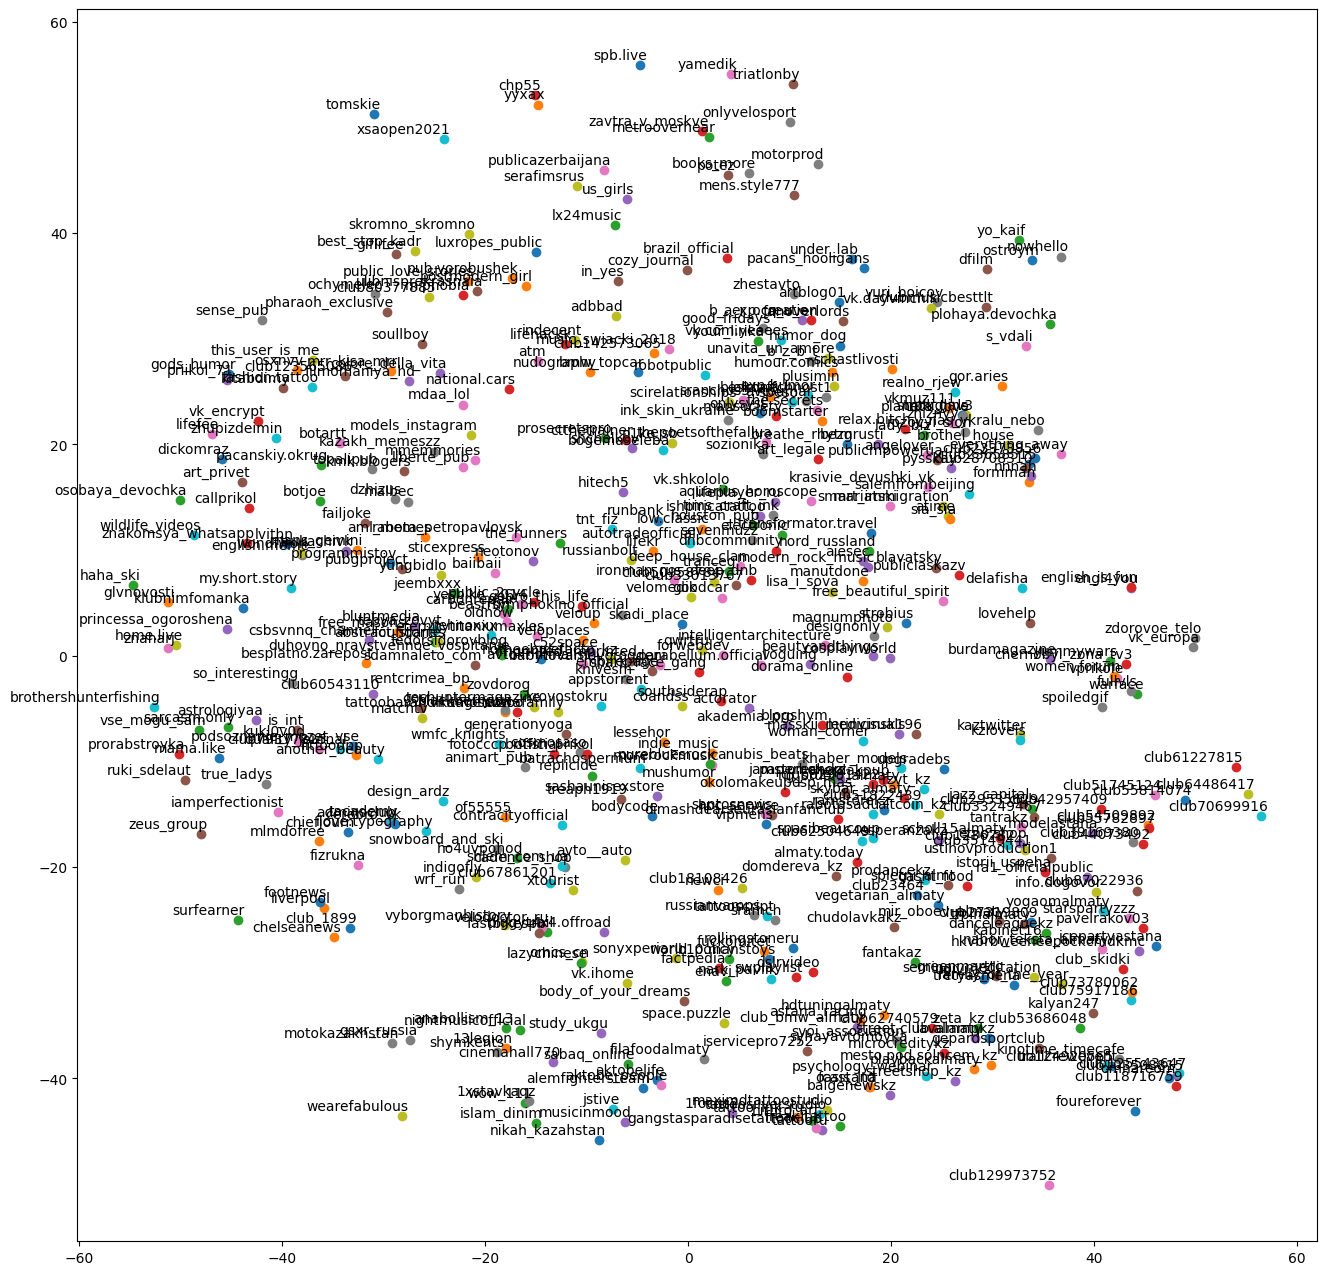

In [42]:
plot_tsne(some_groups_names)

## 5. Apply in your project
You can [download pretrained model](https://drive.google.com/drive/folders/1L_cHapEISPOgUohZN7Tt84f3kj5OHl41?usp=sharing) 
and use it to get user or group features.

Example:

In [24]:
class UserVectorizer:
    def __init__(self, embedding_model_pth: str, users_data: List[dict]):
        embedding_model = gensim.models.KeyedVectors.load(embedding_model_pth)
        self.group2vec_map = self._export_vectors_from_model(embedding_model)
        self.user2data = self._create_user_to_data_map(users_data)
        
    def _create_user_to_data_map(self, users_data: List[dict]):
        user2data = {}
        for sample in users_data:
            user2data[sample["user_id"]] = sample["user_data"]
        return user2data
    
    def _export_vectors_from_model(self, model: gensim.models.KeyedVectors):
        all_groups_ids = model.index_to_key
        all_vecs = [model.get_vector(group_id) for group_id in all_groups_ids]

        group_id_to_vec = {}
        for group_id, vec in zip(all_groups_ids, all_vecs):
            group_id_to_vec[group_id] = vec
        return group_id_to_vec

    def get_user_vector(self, user: str):
        user_groups = self.user2data[user]["groups"]
        
        mean_embed = np.zeros(VECTOR_SIZE)
        cnt_groups_added = 0
        
        for group in user_groups:
            group = str(group)
            if group in self.group2vec_map:
                cnt_groups_added += 1
                mean_embed += self.group2vec_map[group]
                
        return mean_embed / cnt_groups_added


In [25]:
vectorizer = UserVectorizer("../resources/pretrained_models/w2v_33k.kv", users_data=users_data)

In [26]:
print("Some users:")
for sample in users_data[:5]:
    print(sample["user_id"])

Some users:
251073
2397799
177538450
1512858
2674378


In [28]:
user_vector = vectorizer.get_user_vector("251073")
print(user_vector.shape, user_vector[:20])

(300,) [ 0.54511083 -0.26890017 -0.67196952 -0.14238928 -0.17930816 -0.17699027
  0.38363072  1.19074538  0.10379778  0.06293709  0.18826926  0.19950686
  0.11308157  0.39123757  0.10414121  0.14905234  0.43452398 -0.60979888
 -0.926352    0.29128336]
